In [1]:
import zarr
import os
import pandas as pd
from tqdm import tqdm
import glob
import xarray as xr
from matplotlib import pyplot as plt

In [2]:
# Directory containing the files
directory = 'data/test'

# Use glob to find files matching the pattern 'surface_*'
file_pattern = os.path.join(directory, 'surface_*')
filenames = glob.glob(file_pattern)

# Open and concatenate datasets
datasets = []
for file in tqdm(filenames):
    ds = xr.open_dataset(file)
    datasets.append(ds)

# Concatenate all datasets along a time dimension because there is 1 level
surface_df_target = xr.concat(datasets, dim='time').to_dataframe().droplevel(level=[1, 2])  # dimension name 'time' and drop 'lat', 'long'
surface_df_target.drop(surface_df_target.index[-1], inplace=True) 

100%|██████████| 12/12 [00:00<00:00, 166.66it/s]


In [3]:
# Open the .zarr file
store = zarr.open('bench')
surface_dict = {'time': [], 'u10': [], 'v10': [], 't2m': [], 'msl': []}

for fc in sorted(list(store.keys()), key=lambda x: int(x[:-5].split('_')[-1])):
    for var in surface_dict:
        surface_dict[var].extend(store[fc][var][:].squeeze().tolist())
surface_df_pred = pd.DataFrame.from_dict(surface_dict)
surface_df_pred.index = surface_df_target.index

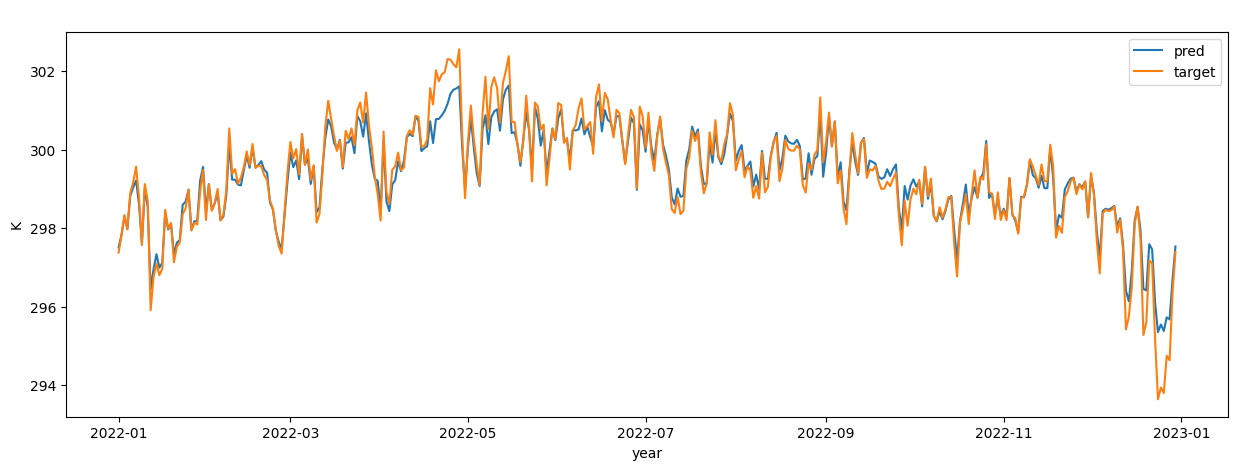

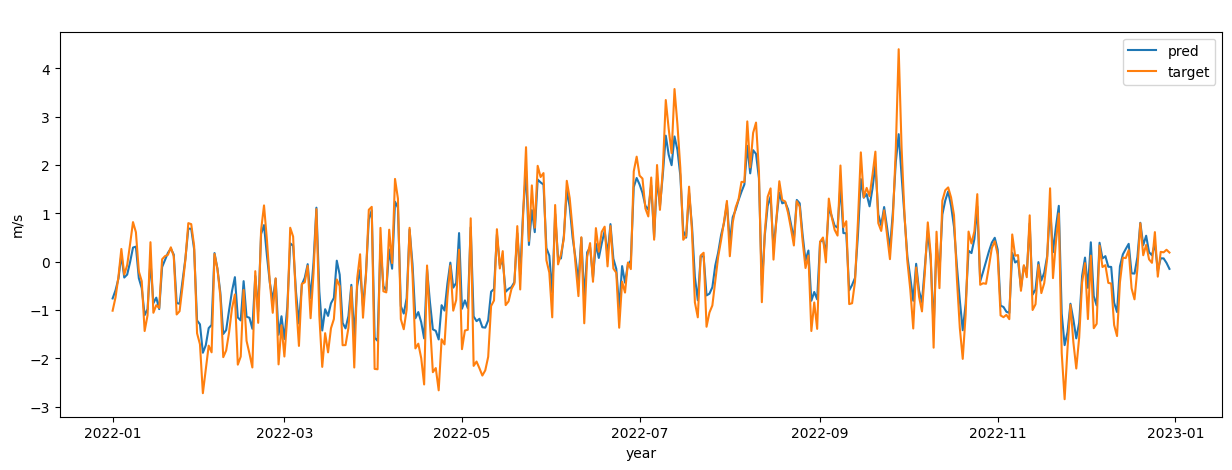

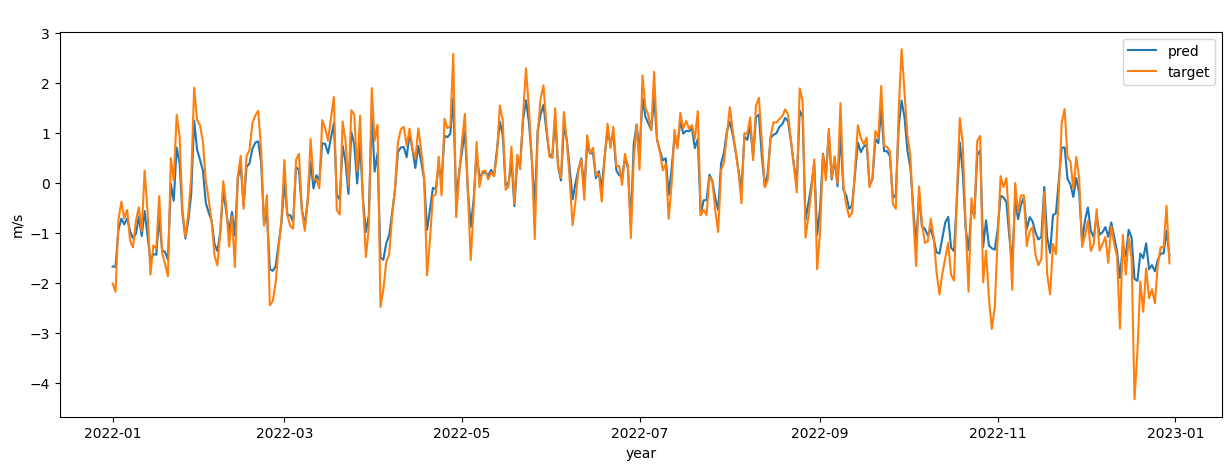

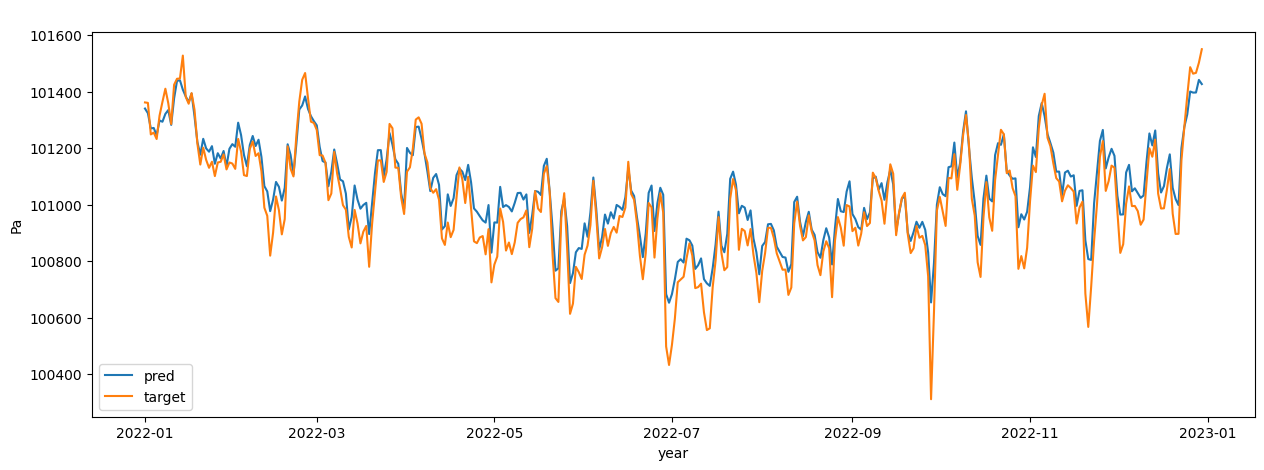

In [4]:
surface_unit_dict = {"t2m": ["2m temperature", "K"],
                     "u10": ["10m u component of wind", "m/s"],
                     "v10": ["10m v component of wind", "m/s"],
                     "msl": ["mean sea level pressure", "Pa"]}

for var in surface_unit_dict:
    plt.figure(figsize=(15, 5))
    plt.plot(surface_df_pred[var], label='pred')
    plt.plot(surface_df_target[var], label='target')
    plt.xlabel("year")
    plt.ylabel(surface_unit_dict[var][1])
    # plt.title(f"{surface_unit_dict[var][0]} ({var}) evaluation")
    plt.title(" ")
    plt.legend()
    plt.savefig(f"evaluation_plot/{var}_evaluation")

In [5]:
# Use glob to find files matching the pattern 'upper_air_*'
file_pattern = os.path.join(directory, 'upper_air_*')
filenames = glob.glob(file_pattern)

# Open and concatenate datasets
datasets = []
for file in tqdm(filenames):
    ds = xr.open_dataset(file)
    datasets.append(ds)

# Concatenate all datasets along a time dimension because there are 13 levels
upper_air_target = xr.concat(datasets, dim='time').to_dataframe().droplevel(level=[2, 3])  # dimension name 'time' and drop 'lat', 'long'
upper_air_target.drop(upper_air_target.index[-1][0], inplace=True)
upper_air_target = upper_air_target.swaplevel(0, 1)

100%|██████████| 12/12 [00:00<00:00, 218.16it/s]


In [6]:
store = zarr.open('bench')
upper_air_dict = {'z': [], 'q': [], 't': [], 'u': [], 'v': []}

for fc in sorted(list(store.keys()), key=lambda x: int(x[:-5].split('_')[-1])):
    for var in upper_air_dict:
        upper_air_dict[var].extend(store[fc][var][:].flatten().tolist())
upper_air_pred = pd.DataFrame.from_dict(upper_air_dict)
upper_air_pred.index = upper_air_target.index

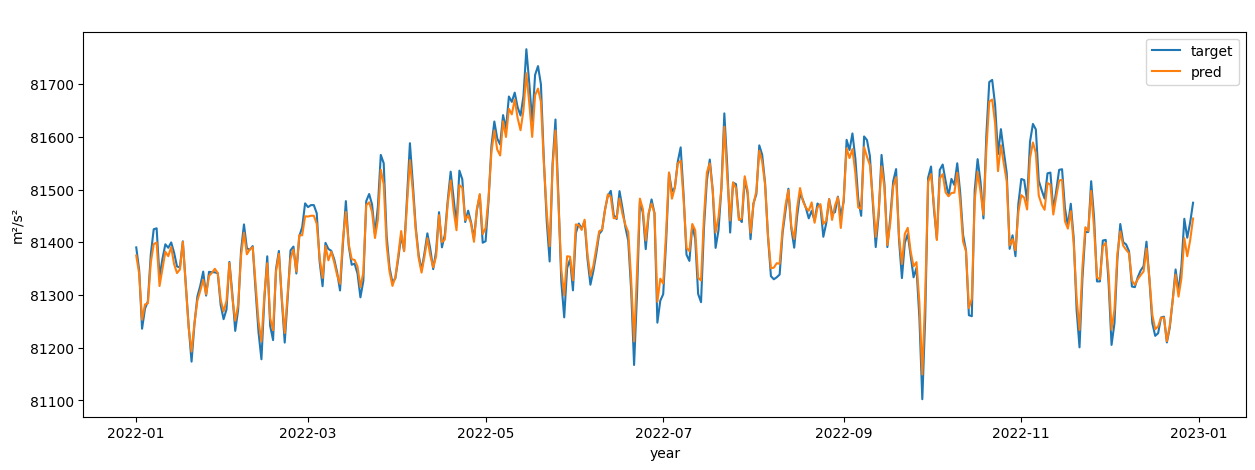

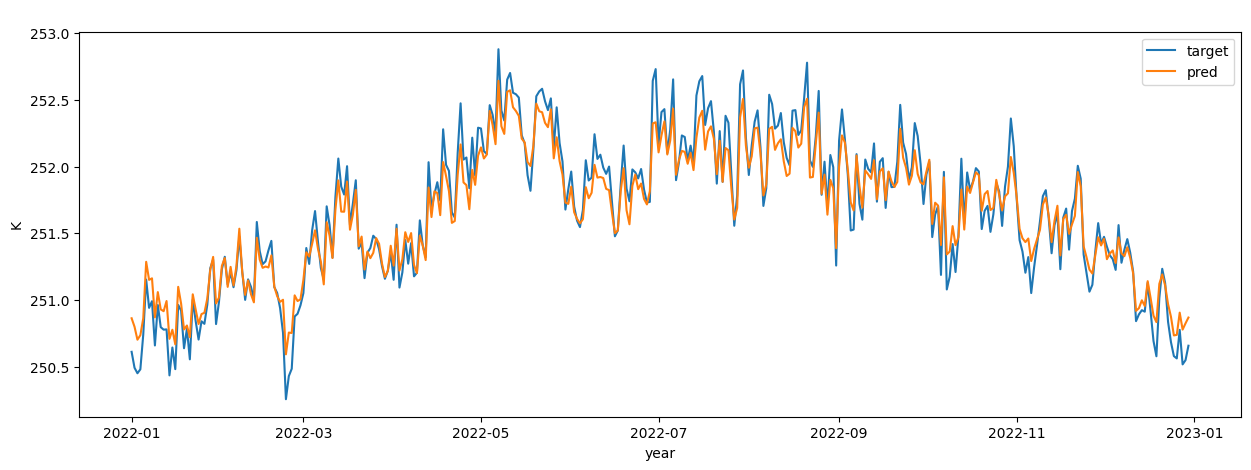

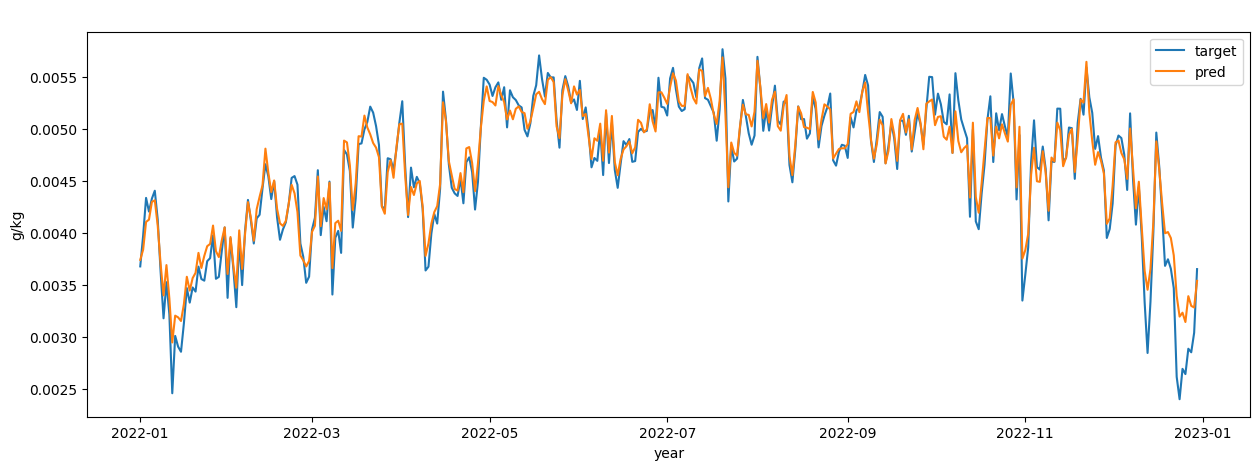

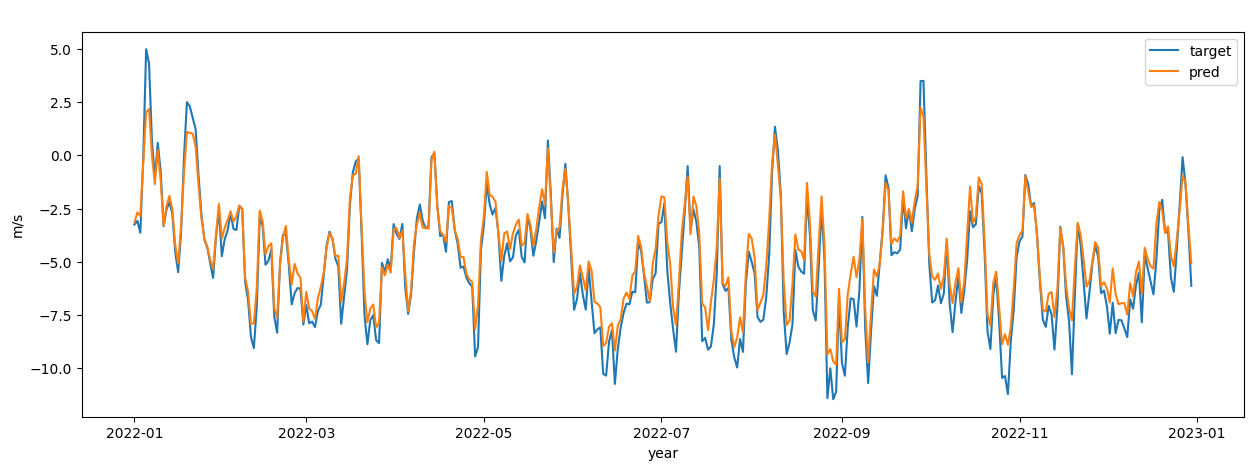

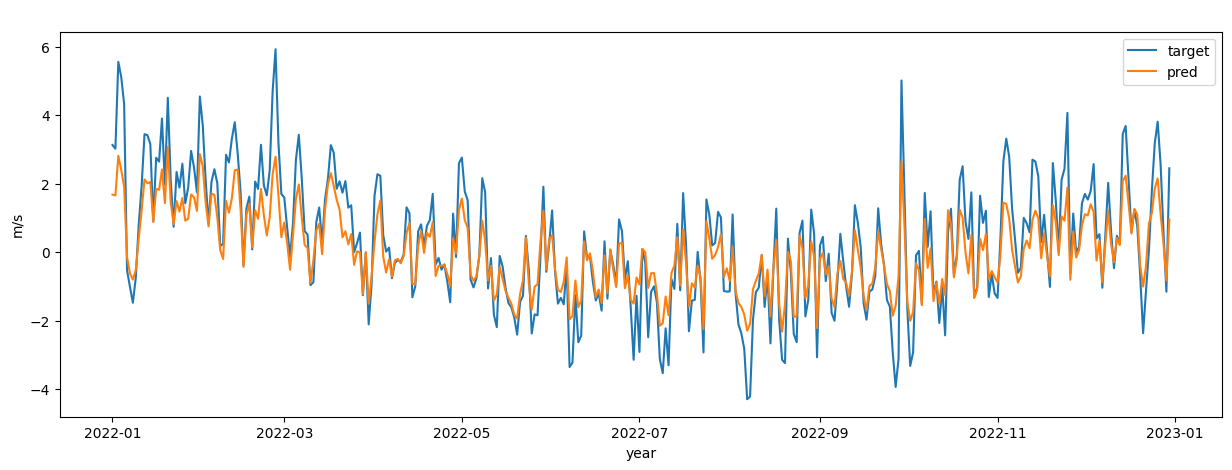

In [7]:
upper_air_dict = {"z": ["geopotential", "m²/s²"],
                  "t": ["tempurature", "K"],
                  "q": ["specific humidity", "g/kg"],
                  "u": ["u component of wind ", "m/s"],
                  "v": ["v component of wind", "m/s"]}

# plot upper air variable change over time by calculate average level
for var in list(upper_air_dict.keys()):
    plt.figure(figsize=(15, 5))
    target = 0
    pred = 0
    n = 0
    for lv in upper_air_target.index.levels[0]:
        target += upper_air_target[upper_air_target.index.get_loc(lv)][var].droplevel(level=[0])
        pred += upper_air_pred[upper_air_pred.index.get_loc(lv)][var].droplevel(level=[0])
        n += 1

    plt.plot(target/n, label='target')
    plt.plot(pred/n, label='pred')
    plt.xlabel("year")
    plt.ylabel(upper_air_dict[var][1])
    # plt.title(f'{upper_air_dict[var][0]} ({var}) evaluation')
    plt.title(' ')
    plt.legend()
    plt.savefig(f"evaluation_plot/{var}_evaluation")